# Locating dune toe on cross-shore beach transects.

_This notebook is from the [pybeach](https://pybeach.readthedocs.io/en/latest/background.html) tutorial examples._

:::{important}
Dunes along sandy coastlines provide an important natural barrier to coastal hazards such as storm-induced waves and surge. The capacity of sandy dunes to provide coastal hazard protection depends in large part on their geometry. In particular, the location of the dune toe (the transition point between the beach and dune) is a key factor used in coastal erosion models and for assessing coastal vulnerability to hazards. 
:::

[pybeach](https://pybeach.readthedocs.io/en/latest/background.html) is a `Python` package for locating the dune toe on cross-shore beach profile transects. The aim is to collate commonly used algorithms for dune toe identification and to provide a new method of locating the dune toe based on machine learning.

[pybeach](https://pybeach.readthedocs.io/en/latest/background.html) identifies the location of the dune toe using the following methods:
1. Maximum curvature (Stockdon, Sallenger, Holman, & Howd, 2007) - the dune toe is defined as the location of maximum slope change;
2. Relative relief (Wernette, Houser, & Bishop, 2016) - the dune toe is defined based on relative relief (the ratio of local morphology to computational scale);
3. Perpendicular distance - the dune toe is defined as the point of maximum perpendicular distance from the straight line drawn between the dune crest and shoreline; and,
4. Machine learning using Random Forest classification

:::{seealso}
A detailed overview of [pybeach](https://pybeach.readthedocs.io/en/latest/background.html) is available in the following [paper](https://joss.theoj.org/papers/10.21105/joss.01890).
:::

In [1]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from beach.beach import Profile
from beach.support import data_support as ds
from beach.support import classifier_support as cs
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import warnings
warnings.simplefilter("ignore", UserWarning)

# Plotting Paramaters
params = {'legend.fontsize': 10,
           'axes.labelsize': 10,
           'axes.labelweight': 'regular',
           'axes.titlesize': 11,
           'axes.titleweight': 'regular',
           'xtick.labelsize': 10,
           'ytick.labelsize': 10,
           'mathtext.default':'regular'}
plt.rcParams.update(params)

## Load the 200 profiles dataset

To test the performance of the dune toe location algorithms, 200 profiles have been made available via the repository. We will load them and visualise some of them:

In [61]:
# Load dataset
with open('../pracenv/dataset/test_profiles.pkl', 'rb') as f:
    data = pickle.load(f)

x, z, toe = data['x'], data['z'], data['toe']
print('Number of profiles: ',len(z))

Number of profiles:  200


### Predicting dune toes

For the ML algorithm, three pre-trained ML models are provided with the **pybeach** package:
1. a “barrier-island” model. This model was developed using 1046 pre- and post- “Hurricane Ivan” airborne LIDAR profiles from Santa-Rosa Island Florida (this data was collected in 2004 and is described in (Doran et al., 2018));
2. a “wave-embayed” model. This model was developed using 1768 pre- and post- “June 2016 storm” airborne LIDAR profiles from the wave-dominated, embayed southeast Australian coastline (this data was collected in 2016 and is described in (Harley et al., 2017)).
3. a “mixed” model. Developed using a combination of the two above datasets.

In [62]:
# Instantiate Profile class
p = Profile(x, z)

# Make predictions of dune toe
toe_ml, prob_ml = p.predict_dunetoe_ml('barrier_island_clf', dune_crest='rr', window_size=101, threshold=0.97)
toe_mc = p.predict_dunetoe_mc(dune_crest='rr', window_size=101, threshold=0.97)
toe_rr = p.predict_dunetoe_rr(dune_crest='rr', window_size=101, threshold=0.97, toe_threshold=0.2, verbose=False)
toe_pd = p.predict_dunetoe_pd(dune_crest='rr', window_size=101, threshold=0.97)

# Predict dune crest
crest = p.predict_dunecrest()
# Predict shoreline
shoreline = p.predict_shoreline()

### Plots 

We will plot some of these profiles. This is done by changing the value of the `n` variable in the cell below.

:::{note}
An additional benefit of the *ML approach* is that it outputs a probability distribution across the length of a profile describing the probability of each individual cross-shore location being a dune toe. This can be particularly useful for correcting errors and interpreting beach morphology.
:::

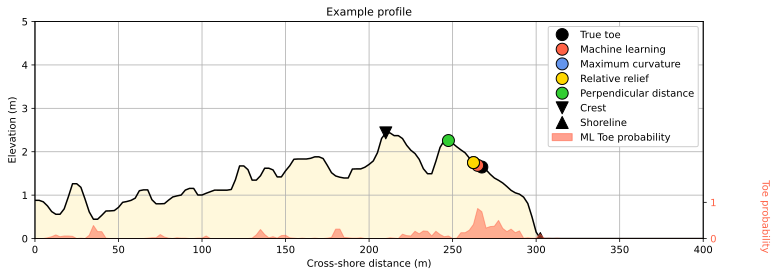

In [64]:
# Specify profile to plot
n = 1

# Figure metadata
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
toes = [toe[n], toe_ml[n], toe_mc[n], toe_rr[n], toe_pd[n]]
labels = ['True toe', 'Machine learning', 'Maximum curvature', 'Relative relief', 'Perpendicular distance']
colors = ['k', 'tomato', 'cornflowerblue', 'gold', 'limegreen']

# Generate figure
axes.plot(x, z[n], '-k')
axes.fill_between([70, 100], [0, 0], y2=-1, color='lightskyblue', alpha=0.5)
axes.fill_between(x, z[n], y2=-1, color='cornsilk', alpha=1)
axes.axvspan(-10, -9, color='tomato', alpha = 0.6, label='ML Toe probability') # legend placeholder
for i, itoe in enumerate(toes): 
    axes.plot(x[itoe], z[n, itoe],
              'o', color=colors[i], ms=12, mec='k', label=labels[i])
axes.plot(x[crest[n]], z[n, crest[n]], 'v', color='k', ms=12, mec='k', label='Crest')
axes.plot(x[shoreline[n]], z[n, shoreline[n]], '^', color='k', ms=12, mec='k', label='Shoreline')
axes.set_xlim(0, 400)
axes.set_ylim(0,5)
axes.set_title('Example profile')
axes.set_xlabel('Cross-shore distance (m)')
axes.set_ylabel('Elevation (m)')
axes.grid()
axes.legend(framealpha=1)

# Plot dune toe ML probability
axes2 = axes.twinx() 
axes2.fill_between(x, prob_ml[n], color='tomato', alpha=0.5)
axes2.set_ylim(0, 6)
axes2.set_yticks([0, 1])
axes2.tick_params(axis='y', labelcolor='tomato')
axes2.yaxis.set_label_coords(1.1, 0.1)
axes2.set_ylabel('Toe probability', color='tomato', rotation=270);

### Performance of the ML algorithm

The profiles dataset comes with the true toe positions for each transect and can be used to evaluate the performance of the different dune toe detection algorithms (ML, MC, RR, PD).

Here we will plot the errors for each methods and see which one is performing better than the other ones:

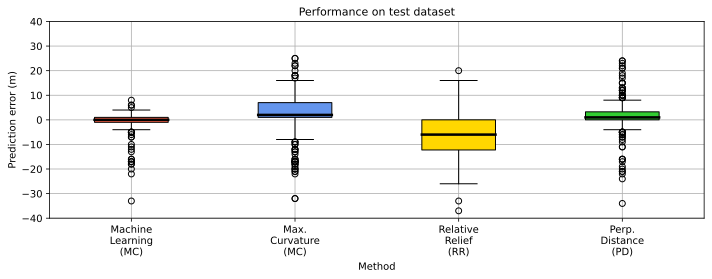

In [52]:
# Figure metadata
fig, axes = plt.subplots(1, 1, figsize=(10,4))
colors = ['tomato', 'cornflowerblue', 'gold', 'limegreen']
labels = ['Machine\nLearning\n(MC)', 'Max.\nCurvature\n(MC)', 'Relative\nRelief\n(RR)', 'Perp.\nDistance\n(PD)']

# Get the errors
data = (toe - np.vstack((toe_ml, toe_mc, toe_rr, toe_pd))).T.astype("float64")

# Box plot
bplot = axes.boxplot(data,
                     labels=labels,
                     patch_artist=True,
                     medianprops = dict(linewidth=2.5, color='k'))

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
axes.set_ylabel('Prediction error (m)')
axes.set_xlabel('Method', labelpad=5)
axes.set_ylim(-40, 40)
axes.grid()
axes.set_title("Performance on test dataset")
plt.tight_layout()

:::{note}
It can be seen that the ML model considerably outperforms the other dune toe location algorithms for this testing set of 200 beach profiles.
:::

We can also use the `Pandas` library to calculate the mean absolute error (**MAE**), root-mean-squared-error (**RMSE**), and r-squared (**R2**) of the four dune toe detection algorithms applied to the 200 test profiles: 

In [53]:
df = pd.DataFrame({'MAE': [np.absolute(toe-toe_ml).mean(),
                           np.absolute(toe-toe_mc).mean(),
                           np.absolute(toe-toe_rr).mean(),
                           np.absolute(toe-toe_pd).mean()],
                   'RMSE': [np.sqrt(np.square(toe-toe_ml).mean()),
                            np.sqrt(np.square(toe-toe_mc).mean()),
                            np.sqrt(np.square(toe-toe_rr).mean()),
                            np.sqrt(np.square(toe-toe_pd).mean())],
                   'R2': [1 - (np.square(toe-toe_ml)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_mc)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_rr)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_pd)).sum() / (np.square(toe-toe.mean())).sum()]},
                  index=['ML', 'MC', 'RR', 'PD']).round(2)
df

,MAE,RMSE,R2
ML,2.40,5.17,0.99
MC,7.59,10.57,0.96
RR,8.59,11.22,0.95
PD,5.18,8.22,0.98


## Using your own dataset

Let say you want to investigate the dune toe prediction on your own set of data. You will have to load it first in the notebooks (maybe as a `CSV` file). 

Here we will create a generic one supposed to be in one of the **embayed beaches** around Sydney:

In [57]:
# X-Z data
x = np.arange(0, 80, 0.5)
z = np.concatenate((np.linspace(4, 5, 40),
                    np.linspace(5, 2, 10),
                    np.linspace(2, 1, 91)[1:],
                    np.linspace(1, 0, 20)))

We then run the different methods available in **pybeach** using the `wave-embayed` model for the ML algorithm:

In [58]:
# instantiate
p = Profile(x, z)

# Predict dune toe location
toe_ml, prob_ml = p.predict_dunetoe_ml('wave_embayed_clf') # use the machine learning (ML) method
toe_mc = p.predict_dunetoe_mc() # use the maximum curvature (MC) method
toe_rr = p.predict_dunetoe_rr() # use the relative relief (RR) method
toe_pd = p.predict_dunetoe_pd() # use the perpendicular distance (PD) method

We can now simply plot the position of the dune town and the probability distribution across the length of our profile

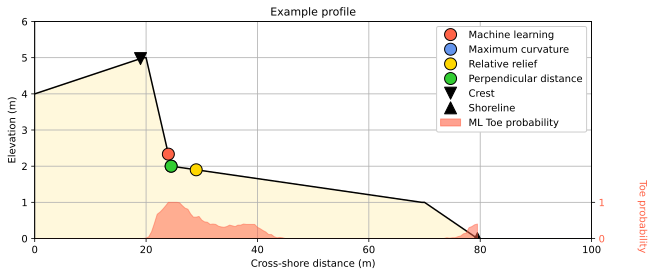

In [59]:
# Predict shoreline and dune crest location
crest = p.predict_dunecrest()
shoreline = p.predict_shoreline()

n=0
fig, axes = plt.subplots(1, 1, figsize=(10, 4))
toes = [toe_ml[n], toe_mc[n], toe_rr[n], toe_pd[n]]

labels = ['Machine learning', 'Maximum curvature', 'Relative relief', 'Perpendicular distance']
colors = ['tomato', 'cornflowerblue', 'gold', 'limegreen']

axes.plot(x, z, '-k')
axes.fill_between([70, 100], [0, 0], y2=-1, color='lightskyblue', alpha=0.5)
axes.fill_between(x, z, y2=-1, color='cornsilk', alpha=1)
axes.axvspan(-10, -9, color='tomato', alpha = 0.6, label='ML Toe probability') # legend placeholder
for i, itoe in enumerate(toes): 
    axes.plot(x[itoe], z[itoe],
              'o', color=colors[i], ms=12, mec='k', label=labels[i])
axes.plot(x[crest[n]], z[crest[n]], 'v', color='k', ms=12, mec='k', label='Crest')
axes.plot(x[shoreline[n]], z[shoreline[n]], '^', color='k', ms=12, mec='k', label='Shoreline')
axes.set_xlim(0, 100)
axes.set_ylim(0, 6)
axes.set_title('Example profile')
axes.set_xlabel('Cross-shore distance (m)')
axes.set_ylabel('Elevation (m)')
axes.grid()
axes.legend(framealpha=1)

# Plot dune toe ML probability
axes2 = axes.twinx() 
axes2.fill_between(x, prob_ml[n], color='tomato', alpha=0.5)
axes2.set_ylim(0, 6)
axes2.set_yticks([0, 1])
axes2.tick_params(axis='y', labelcolor='tomato')
axes2.yaxis.set_label_coords(1.1, 0.1)
axes2.set_ylabel('Toe probability', color='tomato', rotation=270);
fig.show()

As simple as that!